# Model Evaluation and Final Selection

The objective of this notebook is to do a comprehensive evaluation of the best model and final documentation. 

Contents:
1. Load Best Model and Data
2. Comprehensive Metrics Calculation
3. Confusion Matrix Analysis
4. ROC Curve and AUC
5. Feature Importance Analysis
6. Error Analysis
7. Final Model Documentation
8. MLflow logging

## Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
import mlflow
import mlflow.sklearn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
import joblib

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning, module='mlflow')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [3]:
# Define project paths
ROOT = Path.cwd().parent if (Path.cwd().parent / 'data').exists() else Path.cwd()
DATA_PROC = ROOT / "data" / "processed"
MODELS = ROOT / "models"
REPORTS = ROOT / "reports"
FIGS = REPORTS / "figures"

# Create directories
for p in [MODELS, FIGS, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)
    
print(f"\nProject Root: {ROOT}")
print(f"Data Processed: {DATA_PROC}")
print(f"Models: {MODELS}")
print(f"Reports: {REPORTS}")



Project Root: /Users/lia/Desktop/Fase1
Data Processed: /Users/lia/Desktop/Fase1/data/processed
Models: /Users/lia/Desktop/Fase1/models
Reports: /Users/lia/Desktop/Fase1/reports


## Load Best Model and Data

In [6]:
# Load test data
test_data = pd.read_csv(DATA_PROC / 'student_performance_test.csv')
X_test = test_data.drop('Performance_Binary', axis=1)
y_test = test_data['Performance_Binary']

print(f"\n✓ Test data loaded")
print(f" Test samples: {len(X_test)}")
print(f" Features: {X_test.shape[1]}")
print(f" Class distribution: {y_test.value_counts().to_dict()}")

# Load best tuned model
best_model_path = MODELS / "best_model_tuned.pkl"
if best_model_path.exists():
    best_model = joblib.load(best_model_path)
    model_name = best_model.__class__.__name__
    print(f"\n✓ Best model loaded: {model_name}")
    print(f" Model path: {best_model_path}")
    print(f" Model parameters: {best_model.get_params()}")
else:
    print(f"\n⚠ Best model not found at {best_model_path}")
    print(f" Loading baseline model instead...")
    best_model_path = MODELS / "best_model_baseline.pkl"
    best_model = joblib.load(best_model_path)
    model_name = best_model.__class__.__name__
    print(f" Loaded: {model_name}")

# Load tuning results for context
tuning_results_path = REPORTS / "hyperparameter_tuning_results.csv"
if tuning_results_path.exists():
    tuning_results = pd.read_csv(tuning_results_path)
    print(f"\n✓ Tuning results loaded")
else:
    tuning_results = None


✓ Test data loaded
 Test samples: 125
 Features: 30
 Class distribution: {0: 70, 1: 55}

✓ Best model loaded: SVC
 Model path: /Users/lia/Desktop/Fase1/models/best_model_tuned.pkl
 Model parameters: {'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

✓ Tuning results loaded


## Generate Predictions

In [9]:
# Generate predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None

print(f"\nPredictions generated")
print(f" Total predictions: {len(y_pred)}")
print(f" Predicted class distribution: {pd.Series(y_pred).value_counts().to_dict()}")
if y_pred_proba is not None:
    print(f" Probability scores available: Yes")
    print(f" Probability range: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]")


Predictions generated
 Total predictions: 125
 Predicted class distribution: {0: 73, 1: 52}
 Probability scores available: Yes
 Probability range: [0.0362, 0.9857]


## Comprehensive Metrics Calculation

In [10]:
# Calculate all metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)

# Additional metrics
if y_pred_proba is not None:
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
else:
    roc_auc = None
    avg_precision = None

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate additional rates
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate
npv = tn / (tn + fn)   # Negative Predictive Value
ppv = precision        # Positive Predictive Value (same as precision)

print(f"\n{'='*80}")
print("CLASSIFICATION METRICS")
print(f"{'='*80}")
print(f"\nOverall Performance:")
print(f" • Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f" • Precision: {precision:.4f} (How many predicted positives are correct)")
print(f" • Recall:    {recall:.4f} (How many actual positives were found)")
print(f" • F1-Score:  {f1:.4f} (Harmonic mean of precision and recall)")
print(f" • Specificity: {specificity:.4f} (True Negative Rate)")

if roc_auc:
    print(f" • ROC-AUC:   {roc_auc:.4f} (Area under ROC curve)")
if avg_precision:
    print(f" • Avg Precision: {avg_precision:.4f} (Area under PR curve)")

print(f"\nConfusion Matrix Breakdown:")
print(f" • True Negatives (TN):  {tn:3d} - Correctly predicted Lower Performance")
print(f" • False Positives (FP): {fp:3d} - Incorrectly predicted High (Type I Error)")
print(f" • False Negatives (FN): {fn:3d} - Incorrectly predicted Lower (Type II Error)")
print(f" • True Positives (TP):  {tp:3d} - Correctly predicted High Performance")

print(f"\nError Rates:")
print(f" • False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)")
print(f" • False Negative Rate: {fnr:.4f} ({fnr*100:.2f}%)")
print(f" • Negative Predictive Value: {npv:.4f}")
print(f" • Positive Predictive Value: {ppv:.4f}")

# Classification report
print(f"\n{'='*80}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*80}")
class_names = ['Lower Performance (0)', 'High Performance (1)']
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


CLASSIFICATION METRICS

Overall Performance:
 • Accuracy:  0.7200 (72.00%)
 • Precision: 0.6923 (How many predicted positives are correct)
 • Recall:    0.6545 (How many actual positives were found)
 • F1-Score:  0.6729 (Harmonic mean of precision and recall)
 • Specificity: 0.7714 (True Negative Rate)
 • ROC-AUC:   0.8235 (Area under ROC curve)
 • Avg Precision: 0.7775 (Area under PR curve)

Confusion Matrix Breakdown:
 • True Negatives (TN):   54 - Correctly predicted Lower Performance
 • False Positives (FP):  16 - Incorrectly predicted High (Type I Error)
 • False Negatives (FN):  19 - Incorrectly predicted Lower (Type II Error)
 • True Positives (TP):   36 - Correctly predicted High Performance

Error Rates:
 • False Positive Rate: 0.2286 (22.86%)
 • False Negative Rate: 0.3455 (34.55%)
 • Negative Predictive Value: 0.7397
 • Positive Predictive Value: 0.6923

DETAILED CLASSIFICATION REPORT
                       precision    recall  f1-score   support

Lower Performance (0)     

## Confusion Matrix Visualization


Saved confusion matrix to: /Users/lia/Desktop/Fase1/reports/figures/confusion_matrix_20251023_163657.png


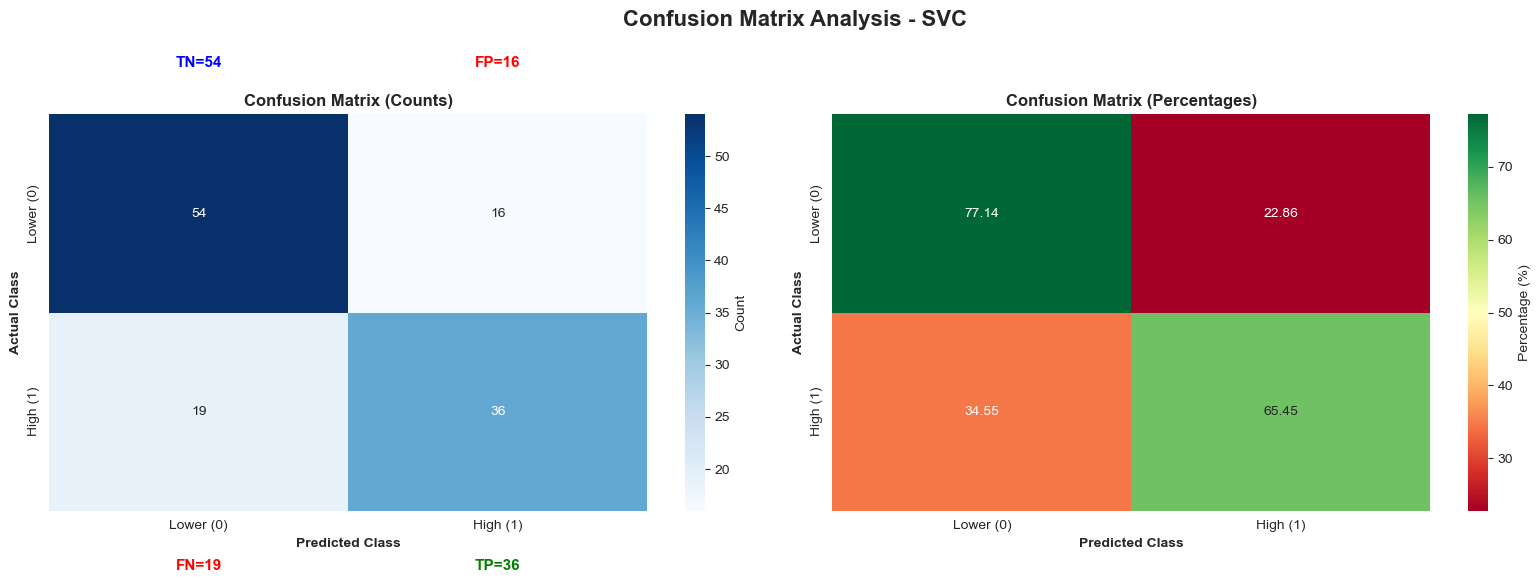

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Confusion Matrix Analysis - {model_name}', fontsize=16, fontweight='bold')

# Confusion Matrix (Counts)
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Lower (0)', 'High (1)'],
            yticklabels=['Lower (0)', 'High (1)'],
            cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Counts)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Actual Class', fontweight='bold')
ax1.set_xlabel('Predicted Class', fontweight='bold')

# Top row: TN (left) and FP (right)
# Bottom row: FN (left) and TP (right)
ax1.text(0.25, 1.12, f'TN={tn}', ha='center', transform=ax1.transAxes, 
         fontsize=11, color='blue', fontweight='bold')
ax1.text(0.75, 1.12, f'FP={fp}', ha='center', transform=ax1.transAxes, 
         fontsize=11, color='red', fontweight='bold')
ax1.text(0.25, -0.15, f'FN={fn}', ha='center', transform=ax1.transAxes, 
         fontsize=11, color='red', fontweight='bold')
ax1.text(0.75, -0.15, f'TP={tp}', ha='center', transform=ax1.transAxes, 
         fontsize=11, color='green', fontweight='bold')

# Confusion Matrix (Percentages)
ax2 = axes[1]
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2,
            xticklabels=['Lower (0)', 'High (1)'],
            yticklabels=['Lower (0)', 'High (1)'],
            cbar_kws={'label': 'Percentage (%)'})
ax2.set_title('Confusion Matrix (Percentages)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Actual Class', fontweight='bold')
ax2.set_xlabel('Predicted Class', fontweight='bold')

plt.tight_layout()

# Save figure
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
cm_path = FIGS / f"confusion_matrix_{ts}.png"
fig.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"\nSaved confusion matrix to: {cm_path}")

plt.show()


## ROC Curve and Precision-Recall Curve


Saved ROC and PR curves to: /Users/lia/Desktop/Fase1/reports/figures/roc_pr_curves_20251023_163657.png


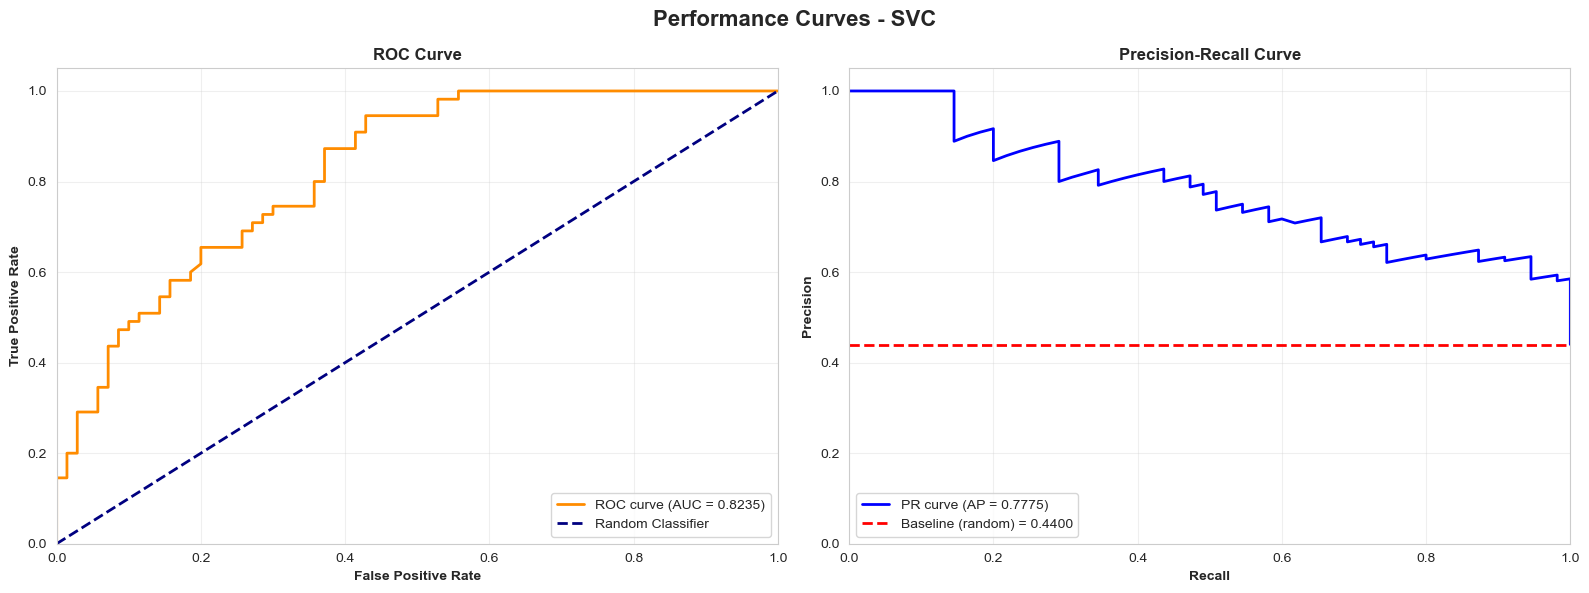

In [19]:
if y_pred_proba is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Performance Curves - {model_name}', fontsize=16, fontweight='bold')
    
    # ROC Curve
    ax1 = axes[0]
    fpr_curve, tpr_curve, thresholds_roc = roc_curve(y_test, y_pred_proba)
    
    ax1.plot(fpr_curve, tpr_curve, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontweight='bold')
    ax1.set_title('ROC Curve', fontweight='bold', fontsize=12)
    ax1.legend(loc="lower right")
    ax1.grid(alpha=0.3)
    
    # Precision-Recall Curve
    ax2 = axes[1]
    precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
    
    ax2.plot(recall_curve, precision_curve, color='blue', lw=2,
             label=f'PR curve (AP = {avg_precision:.4f})')
    ax2.axhline(y=y_test.mean(), color='red', linestyle='--', lw=2,
                label=f'Baseline (random) = {y_test.mean():.4f}')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontweight='bold')
    ax2.set_ylabel('Precision', fontweight='bold')
    ax2.set_title('Precision-Recall Curve', fontweight='bold', fontsize=12)
    ax2.legend(loc="lower left")
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    roc_path = FIGS / f"roc_pr_curves_{ts}.png"
    fig.savefig(roc_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved ROC and PR curves to: {roc_path}")
    
    plt.show()
else:
    print(f"\n⚠ Probability scores not available - skipping ROC/PR curves")

## Feature Importance Analysis


Model coefficients available

Top 10 Most Important Features (by absolute coefficient):
                          Feature  Coefficient  Abs_Coefficient
         Mother_occupation_OTHERS    -3.546268         3.546268
 Mother_occupation_SCHOOL_TEACHER    -3.545548         3.545548
     Mother_occupation_HOUSE_WIFE    -3.375290         3.375290
                         Caste_ST    -2.635814         2.635814
         Mother_occupation_DOCTOR    -2.634207         2.634207
Mother_occupation_COLLEGE_TEACHER    -2.060890         2.060890
       Mother_occupation_BUSINESS    -2.052971         2.052971
                         Caste_SC    -1.999675         1.999675
                        Caste_OBC    -1.372017         1.372017
            twelve_education_CBSE    -1.202423         1.202423

Saved feature coefficients to: /Users/lia/Desktop/Fase1/reports/figures/feature_coefficients_20251023_163657.png


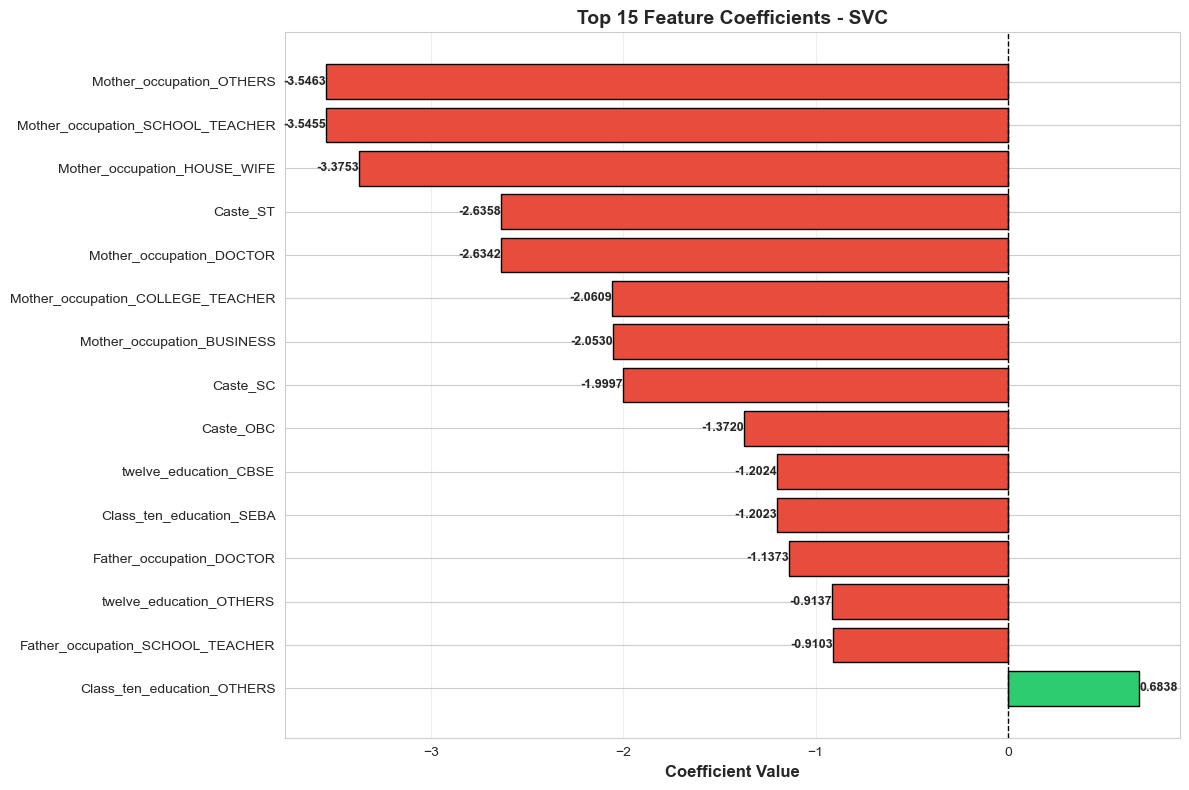

In [20]:
# Check if model has feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    feature_names = X_test.columns
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print(f"\nFeature importance available")
    print(f"\nTop 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))
    
    # Visualize top 15 features
    fig, ax = plt.subplots(figsize=(12, 8))
    top_features = importance_df.head(15)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    bars = ax.barh(top_features['Feature'], top_features['Importance'],
                   color=colors, edgecolor='black')
    
    ax.set_xlabel('Importance', fontweight='bold', fontsize=12)
    ax.set_title(f'Top 15 Feature Importances - {model_name}', 
                 fontweight='bold', fontsize=14)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', ha='left', va='center',
                fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    importance_path = FIGS / f"feature_importance_{ts}.png"
    fig.savefig(importance_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved feature importance to: {importance_path}")
    
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # For linear models (like Logistic Regression, SVM with linear kernel)
    coefficients = best_model.coef_[0]
    feature_names = X_test.columns
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(f"\nModel coefficients available")
    print(f"\nTop 10 Most Important Features (by absolute coefficient):")
    print(importance_df[['Feature', 'Coefficient', 'Abs_Coefficient']].head(10).to_string(index=False))
    
    # Visualize top 15 features
    fig, ax = plt.subplots(figsize=(12, 8))
    top_features = importance_df.head(15)
    
    colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in top_features['Coefficient']]
    bars = ax.barh(top_features['Feature'], top_features['Coefficient'],
                   color=colors, edgecolor='black')
    
    ax.set_xlabel('Coefficient Value', fontweight='bold', fontsize=12)
    ax.set_title(f'Top 15 Feature Coefficients - {model_name}', 
                 fontweight='bold', fontsize=14)
    ax.invert_yaxis()
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', ha='left' if width > 0 else 'right', va='center',
                fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    importance_path = FIGS / f"feature_coefficients_{ts}.png"
    fig.savefig(importance_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved feature coefficients to: {importance_path}")
    
    plt.show()
    
else:
    print(f"\n⚠ Feature importance not available for {model_name}")
    importance_df = None

# Error Analysis


Error Statistics:
 Total misclassified: 35 out of 125 (28.00%)
 False Positives: 16 (Predicted High, Actually Lower)
 False Negatives: 19 (Predicted Lower, Actually High)

Misclassification Analysis:

False Positives (Predicted High, Actually Lower):
  Count: 16
  Average confidence: 0.6251

False Negatives (Predicted Lower, Actually High):
 Count: 19
 Average confidence: 0.3275

Saved confidence analysis to: /Users/lia/Desktop/Fase1/reports/figures/prediction_confidence_20251023_163657.png


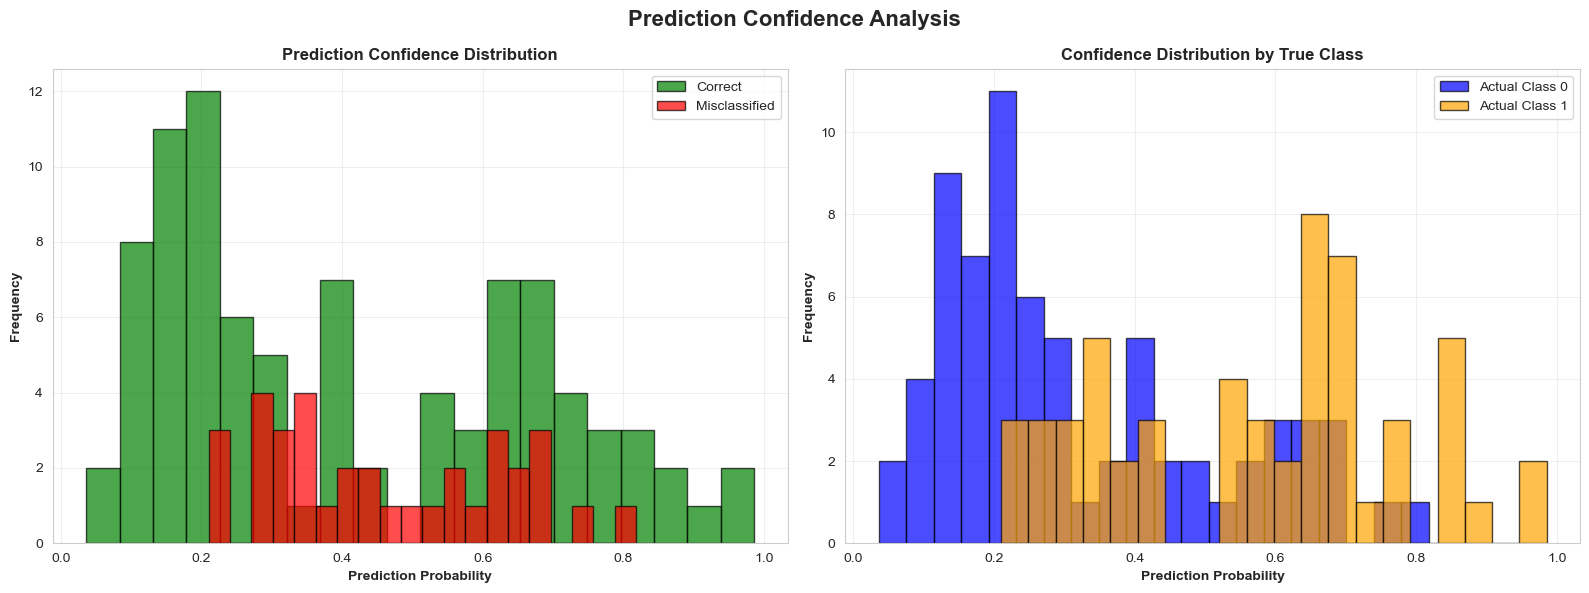

In [21]:
# Identify misclassified samples
misclassified_idx = y_test != y_pred
n_misclassified = misclassified_idx.sum()

print(f"\nError Statistics:")
print(f" Total misclassified: {n_misclassified} out of {len(y_test)} ({n_misclassified/len(y_test)*100:.2f}%)")
print(f" False Positives: {fp} (Predicted High, Actually Lower)")
print(f" False Negatives: {fn} (Predicted Lower, Actually High)")

if n_misclassified > 0:
    # Analyze misclassified samples
    error_df = pd.DataFrame({
        'Actual': y_test[misclassified_idx].values,
        'Predicted': y_pred[misclassified_idx],
        'Probability': y_pred_proba[misclassified_idx] if y_pred_proba is not None else [None]*n_misclassified
    })
    
    print(f"\nMisclassification Analysis:")
    print(f"\nFalse Positives (Predicted High, Actually Lower):")
    fp_mask = (error_df['Actual'] == 0) & (error_df['Predicted'] == 1)
    if fp_mask.sum() > 0:
        if y_pred_proba is not None:
            avg_prob_fp = error_df[fp_mask]['Probability'].mean()
            print(f"  Count: {fp_mask.sum()}")
            print(f"  Average confidence: {avg_prob_fp:.4f}")
        else:
            print(f"  Count: {fp_mask.sum()}")
    
    print(f"\nFalse Negatives (Predicted Lower, Actually High):")
    fn_mask = (error_df['Actual'] == 1) & (error_df['Predicted'] == 0)
    if fn_mask.sum() > 0:
        if y_pred_proba is not None:
            avg_prob_fn = error_df[fn_mask]['Probability'].mean()
            print(f" Count: {fn_mask.sum()}")
            print(f" Average confidence: {avg_prob_fn:.4f}")
        else:
            print(f" Count: {fn_mask.sum()}")
    
    # Visualize prediction confidence distribution
    if y_pred_proba is not None:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Prediction Confidence Analysis', fontsize=16, fontweight='bold')
        
        # Confidence distribution for all predictions
        ax1 = axes[0]
        correct_mask = ~misclassified_idx
        ax1.hist(y_pred_proba[correct_mask], bins=20, alpha=0.7, label='Correct', color='green', edgecolor='black')
        ax1.hist(y_pred_proba[misclassified_idx], bins=20, alpha=0.7, label='Misclassified', color='red', edgecolor='black')
        ax1.set_xlabel('Prediction Probability', fontweight='bold')
        ax1.set_ylabel('Frequency', fontweight='bold')
        ax1.set_title('Prediction Confidence Distribution', fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # Confidence by class
        ax2 = axes[1]
        class_0_probs = y_pred_proba[y_test == 0]
        class_1_probs = y_pred_proba[y_test == 1]
        ax2.hist(class_0_probs, bins=20, alpha=0.7, label='Actual Class 0', color='blue', edgecolor='black')
        ax2.hist(class_1_probs, bins=20, alpha=0.7, label='Actual Class 1', color='orange', edgecolor='black')
        ax2.set_xlabel('Prediction Probability', fontweight='bold')
        ax2.set_ylabel('Frequency', fontweight='bold')
        ax2.set_title('Confidence Distribution by True Class', fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        confidence_path = FIGS / f"prediction_confidence_{ts}.png"
        fig.savefig(confidence_path, dpi=300, bbox_inches='tight')
        print(f"\nSaved confidence analysis to: {confidence_path}")
        
        plt.show()

## Model Card Documentation

In [23]:
model_card = f"""
{'='*80}
MODEL CARD - STUDENT PERFORMANCE PREDICTION
{'='*80}

Model Information
-----------------
• Model Type: {model_name}
• Task: Binary Classification
• Target: Student Performance (0: Lower, 1: High)
• Training Date: {datetime.now().strftime('%Y-%m-%d')}
• Model Path: {best_model_path}

Dataset Information
-------------------
• Total Samples: {len(y_test)} (test set)
• Features: {X_test.shape[1]}
• Class Distribution:
  - Class 0 (Lower): {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)
  - Class 1 (High): {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)

Performance Metrics (Test Set)
-------------------------------
• Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)
• Precision:   {precision:.4f}
• Recall:      {recall:.4f}
• F1-Score:    {f1:.4f}
• Specificity: {specificity:.4f}
• ROC-AUC:     {roc_auc:.4f}

Confusion Matrix
----------------
                    Predicted
                 Lower  |  High
Actual   Lower    {tn:3d}   |  {fp:3d}
         High     {fn:3d}   |  {tp:3d}

Error Analysis
--------------
• False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)
• False Negative Rate: {fnr:.4f} ({fnr*100:.2f}%)
• Total Errors: {n_misclassified}/{len(y_test)} ({n_misclassified/len(y_test)*100:.2f}%)

Model Parameters
----------------
{best_model.get_params()}

Intended Use
------------
• Primary Use: Predict student entrance exam performance
• Users: Educational institutions, admissions teams
• Out-of-Scope: Not for individual student evaluation or high-stakes decisions

Limitations
-----------
• Model trained on specific demographic and academic context
• Performance may vary with different populations
• Should be used as one factor among many in decision-making
• Regular retraining recommended with new data

Ethical Considerations
----------------------
• Potential for bias based on demographic features
• Should not be sole determinant of student outcomes
• Transparency in feature importance required
• Regular fairness audits recommended

Deployment Readiness
--------------------
✓ Model trained and validated
✓ Performance metrics documented
✓ Feature importance analyzed
✓ Error analysis completed
✓ Model card created
{'✓ Saved to MLflow' if roc_auc else ''}

Recommendations
---------------
• Monitor model performance over time
• Collect feedback from end users
• Retrain periodically with new data
• Consider ensemble methods for improvement
• Implement model monitoring in production

Contact Information
-------------------
• Team: MLOps Team 16
• Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
• Version: 1.0

{'='*80}
"""

print(model_card)

# Save model card
model_card_path = REPORTS / "model_card.txt"
with open(model_card_path, 'w') as f:
    f.write(model_card)
print(f"\nModel card saved to: {model_card_path}")


MODEL CARD - STUDENT PERFORMANCE PREDICTION

Model Information
-----------------
• Model Type: SVC
• Task: Binary Classification
• Target: Student Performance (0: Lower, 1: High)
• Training Date: 2025-10-23
• Model Path: /Users/lia/Desktop/Fase1/models/best_model_tuned.pkl

Dataset Information
-------------------
• Total Samples: 125 (test set)
• Features: 30
• Class Distribution:
  - Class 0 (Lower): 70 (56.0%)
  - Class 1 (High): 55 (44.0%)

Performance Metrics (Test Set)
-------------------------------
• Accuracy:    0.7200 (72.00%)
• Precision:   0.6923
• Recall:      0.6545
• F1-Score:    0.6729
• Specificity: 0.7714
• ROC-AUC:     0.8235

Confusion Matrix
----------------
                    Predicted
                 Lower  |  High
Actual   Lower     54   |   16
         High      19   |   36

Error Analysis
--------------
• False Positive Rate: 0.2286 (22.86%)
• False Negative Rate: 0.3455 (34.55%)
• Total Errors: 35/125 (28.00%)

Model Parameters
----------------
{'C': 100, '

## MLflow Logging

In [24]:
# Set MLflow tracking
mlflow_dir = ROOT / "mlruns"
mlflow.set_tracking_uri(f"file://{mlflow_dir}")
mlflow.set_experiment("student_performance_final_evaluation")

print(f"\nLogging final evaluation to MLflow...")

with mlflow.start_run(run_name=f"final_evaluation_{model_name}"):
    
    # Log model info
    mlflow.log_param("model_type", model_name)
    mlflow.log_param("model_path", str(best_model_path))
    mlflow.log_param("evaluation_date", datetime.now().strftime('%Y-%m-%d'))
    
    # Log all metrics
    mlflow.log_metric("final_accuracy", accuracy)
    mlflow.log_metric("final_precision", precision)
    mlflow.log_metric("final_recall", recall)
    mlflow.log_metric("final_f1", f1)
    mlflow.log_metric("final_specificity", specificity)
    
    if roc_auc:
        mlflow.log_metric("final_roc_auc", roc_auc)
    if avg_precision:
        mlflow.log_metric("final_avg_precision", avg_precision)
    
    # Log confusion matrix values
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)
    mlflow.log_metric("true_positives", tp)
    
    # Log error rates
    mlflow.log_metric("false_positive_rate", fpr)
    mlflow.log_metric("false_negative_rate", fnr)
    
    # Log artifacts (figures and reports)
    mlflow.log_artifact(str(cm_path))
    if y_pred_proba is not None:
        mlflow.log_artifact(str(roc_path))
        mlflow.log_artifact(str(confidence_path))
    if importance_df is not None:
        mlflow.log_artifact(str(importance_path))
    mlflow.log_artifact(str(model_card_path))
    
    print(f"\n✓ Metrics logged to MLflow")
    print(f"✓ Artifacts logged to MLflow")

print(f"\nView MLflow UI: Run 'mlflow ui' in project root")

2025/10/23 16:41:42 INFO mlflow.tracking.fluent: Experiment with name 'student_performance_final_evaluation' does not exist. Creating a new experiment.



Logging final evaluation to MLflow...

✓ Metrics logged to MLflow
✓ Artifacts logged to MLflow

View MLflow UI: Run 'mlflow ui' in project root


## Final Summary

In [27]:
print(f"\nFINAL MODEL SELECTION:")
print(f" • Selected Model: {model_name}")
print(f" • Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f" • F1-Score: {f1:.4f}")
print(f" • ROC-AUC: {roc_auc:.4f}")

print(f"\nPERFORMANCE ASSESSMENT:")
if accuracy >= 0.80:
    assessment = "Excellent"
elif accuracy >= 0.75:
    assessment = "Good"
elif accuracy >= 0.70:
    assessment = "Acceptable"
else:
    assessment = "Needs Improvement"

print(f"Overall Rating: {assessment}")
print(f" • Precision-Recall Balance: {'Balanced' if abs(precision - recall) < 0.05 else 'Imbalanced'}")
print(f" • Error Rate: {(1-accuracy)*100:.2f}%")
print(f" • Misclassifications: {n_misclassified}/{len(y_test)}")

print(f"\nARTIFACTS CREATED:")
artifacts = [
    cm_path.name,
    model_card_path.name
]
if y_pred_proba is not None:
    artifacts.extend([roc_path.name, confidence_path.name])
if importance_df is not None:
    artifacts.append(importance_path.name)

for artifact in artifacts:
    print(f"  ✓ {artifact}")

print(f"\nKEY INSIGHTS:")
print(f" • Model correctly classifies {accuracy*100:.1f}% of students")
print(f" • {fp} students predicted as High but actually Lower (False Positives)")
print(f" • {fn} students predicted as Lower but actually High (False Negatives)")

if importance_df is not None:
    top_feature = importance_df.iloc[0]['Feature']
    print(f" • Most important feature: {top_feature}")

print(f"\nRECOMMENDATIONS:")
if accuracy < 0.75:
    print(f" • Consider collecting more training data")
    print(f" • Explore additional feature engineering")
    print(f" • Try ensemble methods or deep learning")
elif accuracy < 0.85:
    print(f" • Model performs well, consider deployment")
    print(f" • Monitor performance in production")
    print(f" • Collect user feedback for improvements")
else:
    print(f" • Excellent performance - ready for deployment")
    print(f" • Implement A/B testing in production")
    print(f" • Document lessons learned")

print(f"\nDEPLOYMENT CHECKLIST:")
checklist = [
    ("Model trained and validated", True),
    ("Performance metrics documented", True),
    ("Confusion matrix analyzed", True),
    ("Feature importance documented", importance_df is not None),
    ("Error analysis completed", True),
    ("Model card created", True),
    ("MLflow logging completed", True),
    ("Meets accuracy threshold (70%)", accuracy >= 0.70)
]

for item, status in checklist:
    symbol = "✓" if status else "✗"
    print(f"{symbol} {item}")

deployment_ready = all([status for _, status in checklist])
print(f"\n{'MODEL READY FOR DEPLOYMENT!' if deployment_ready else '⚠️ ADDRESS ISSUES BEFORE DEPLOYMENT'}")

print(f"\n{'='*80}")
print("MODEL EVALUATION COMPLETE")
print(f"{'='*80}")


FINAL MODEL SELECTION:
 • Selected Model: SVC
 • Test Accuracy: 0.7200 (72.00%)
 • F1-Score: 0.6729
 • ROC-AUC: 0.8235

PERFORMANCE ASSESSMENT:
Overall Rating: Acceptable
 • Precision-Recall Balance: Balanced
 • Error Rate: 28.00%
 • Misclassifications: 35/125

ARTIFACTS CREATED:
  ✓ confusion_matrix_20251023_163657.png
  ✓ model_card.txt
  ✓ roc_pr_curves_20251023_163657.png
  ✓ prediction_confidence_20251023_163657.png
  ✓ feature_coefficients_20251023_163657.png

KEY INSIGHTS:
 • Model correctly classifies 72.0% of students
 • 16 students predicted as High but actually Lower (False Positives)
 • 19 students predicted as Lower but actually High (False Negatives)
 • Most important feature: Mother_occupation_OTHERS

RECOMMENDATIONS:
 • Consider collecting more training data
 • Explore additional feature engineering
 • Try ensemble methods or deep learning

DEPLOYMENT CHECKLIST:
✓ Model trained and validated
✓ Performance metrics documented
✓ Confusion matrix analyzed
✓ Feature importa

## Save Results


✓ Results saved to: /Users/lia/Desktop/Fase1/reports/final_evaluation_results.json
✓ Results saved to: /Users/lia/Desktop/Fase1/reports/final_evaluation_results.csv
✓ Feature importance saved to: /Users/lia/Desktop/Fase1/reports/feature_importance.csv
✓ Evaluation summary saved to: /Users/lia/Desktop/Fase1/reports/figures/evaluation_summary_20251023_163657.png


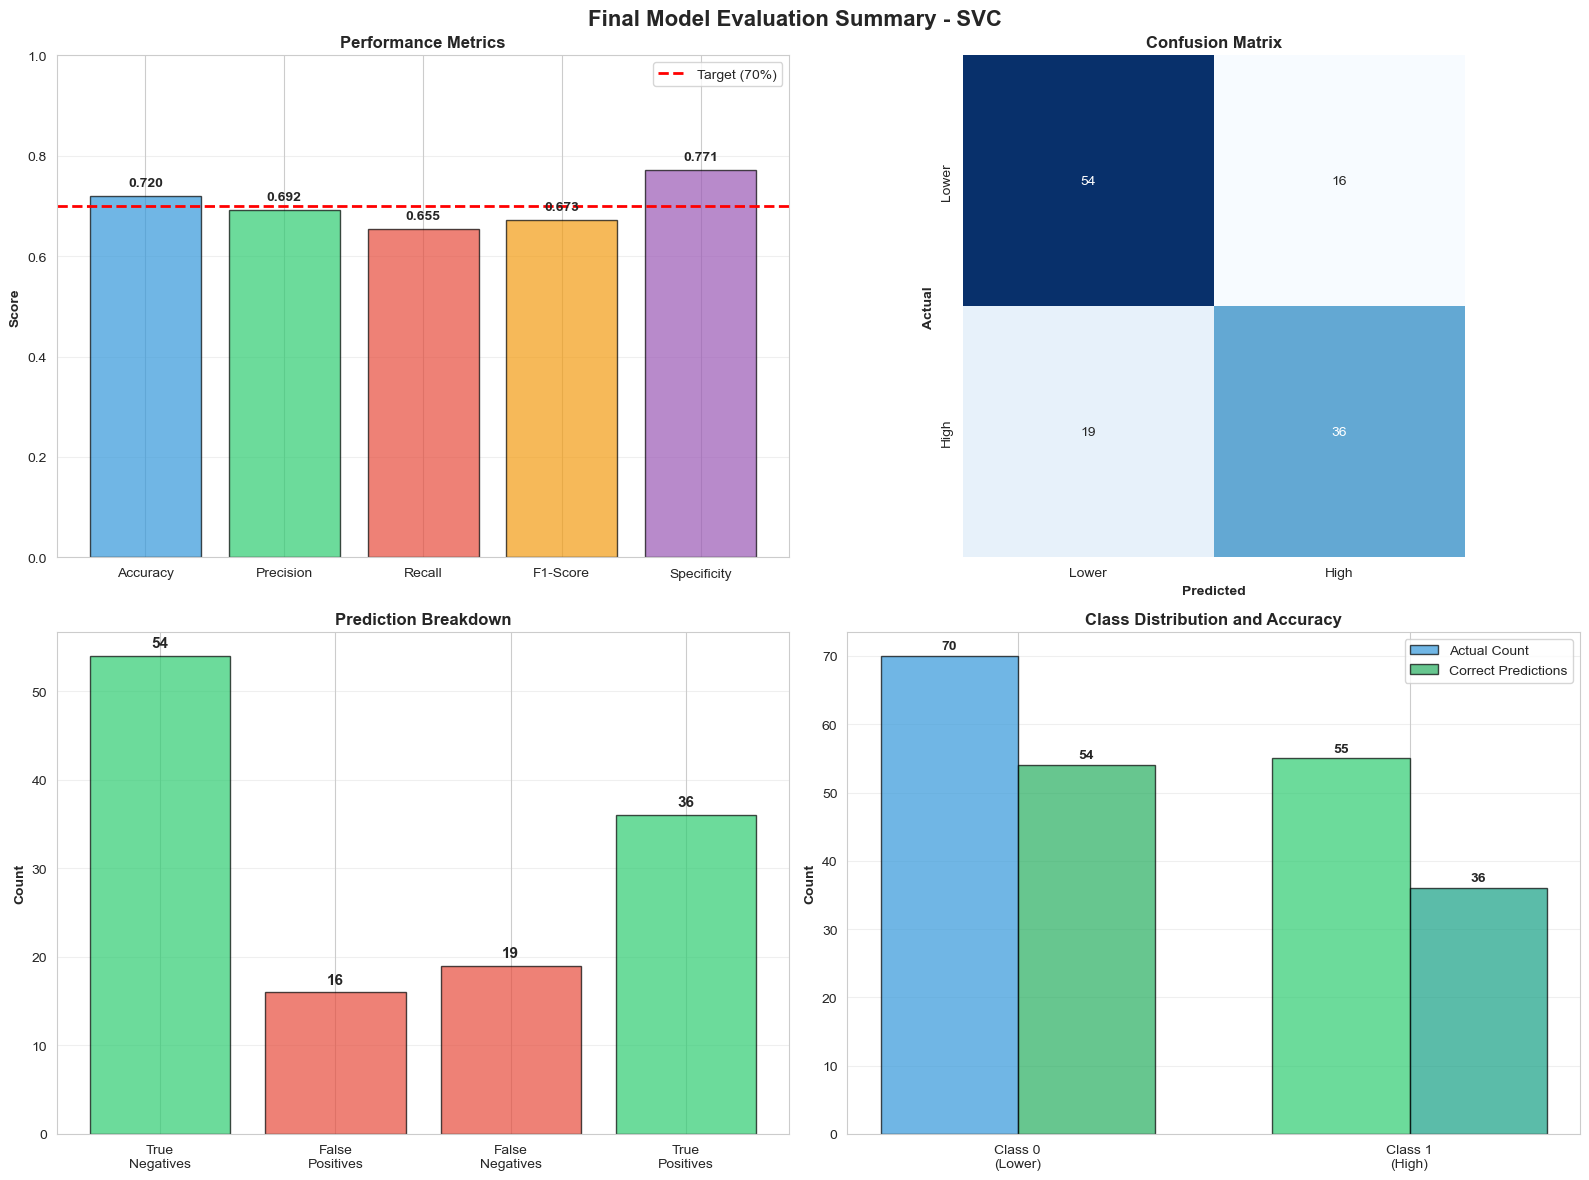


ALL RESULTS SAVED SUCCESSFULLY!

Complete Artifact List:
 1. confusion_matrix_20251023_163657.png
 2. model_card.txt
 3. final_evaluation_results.json
 4. final_evaluation_results.csv
 5. evaluation_summary_20251023_163657.png
 6. roc_pr_curves_20251023_163657.png
 7. prediction_confidence_20251023_163657.png
 8. feature_importance.csv


In [28]:
# Create comprehensive results dictionary
final_results = {
    'model_name': model_name,
    'model_path': str(best_model_path),
    'evaluation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_samples': len(y_test),
    'features': X_test.shape[1],
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'specificity': specificity,
    'roc_auc': roc_auc if roc_auc else None,
    'avg_precision': avg_precision if avg_precision else None,
    'true_negatives': int(tn),
    'false_positives': int(fp),
    'false_negatives': int(fn),
    'true_positives': int(tp),
    'false_positive_rate': fpr,
    'false_negative_rate': fnr,
    'total_errors': int(n_misclassified),
    'error_rate': n_misclassified/len(y_test),
    'assessment': assessment,
    'deployment_ready': deployment_ready
}

# Save as JSON
import json
results_json_path = REPORTS / "final_evaluation_results.json"
with open(results_json_path, 'w') as f:
    json.dump(final_results, f, indent=4)
print(f"\n✓ Results saved to: {results_json_path}")

# Save as CSV
results_csv_path = REPORTS / "final_evaluation_results.csv"
pd.DataFrame([final_results]).to_csv(results_csv_path, index=False)
print(f"✓ Results saved to: {results_csv_path}")

# Save feature importance if available
if importance_df is not None:
    importance_csv_path = REPORTS / "feature_importance.csv"
    importance_df.to_csv(importance_csv_path, index=False)
    print(f"✓ Feature importance saved to: {importance_csv_path}")

# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Final Model Evaluation Summary - {model_name}', fontsize=16, fontweight='bold')

# 1. Metrics comparison bar chart
ax1 = axes[0, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
values = [accuracy, precision, recall, f1, specificity]
colors_metrics = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
bars = ax1.bar(metrics, values, color=colors_metrics, edgecolor='black', alpha=0.7)
ax1.set_ylim([0, 1])
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Performance Metrics', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0.7, color='red', linestyle='--', linewidth=2, label='Target (70%)')
ax1.legend()

# Add value labels
for bar, val in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.3f}', ha='center', fontweight='bold', fontsize=10)

# 2. Confusion Matrix (compact)
ax2 = axes[0, 1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Lower', 'High'],
            yticklabels=['Lower', 'High'],
            cbar=False, square=True)
ax2.set_title('Confusion Matrix', fontweight='bold')
ax2.set_ylabel('Actual', fontweight='bold')
ax2.set_xlabel('Predicted', fontweight='bold')

# 3. Error breakdown
ax3 = axes[1, 0]
error_labels = ['True\nNegatives', 'False\nPositives', 'False\nNegatives', 'True\nPositives']
error_values = [tn, fp, fn, tp]
error_colors = ['#2ecc71', '#e74c3c', '#e74c3c', '#2ecc71']
bars_error = ax3.bar(error_labels, error_values, color=error_colors, edgecolor='black', alpha=0.7)
ax3.set_ylabel('Count', fontweight='bold')
ax3.set_title('Prediction Breakdown', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars_error, error_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val}', ha='center', fontweight='bold', fontsize=11)

# 4. Class distribution and accuracy
ax4 = axes[1, 1]
class_labels = ['Class 0\n(Lower)', 'Class 1\n(High)']
class_counts = [(y_test == 0).sum(), (y_test == 1).sum()]
class_colors = ['#3498db', '#2ecc71']

# Create grouped bar chart
x_pos = np.arange(len(class_labels))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, class_counts, width, label='Actual Count',
                color=class_colors, edgecolor='black', alpha=0.7)

# Calculate correct predictions per class
correct_class_0 = ((y_test == 0) & (y_pred == 0)).sum()
correct_class_1 = ((y_test == 1) & (y_pred == 1)).sum()
correct_counts = [correct_class_0, correct_class_1]

bars2 = ax4.bar(x_pos + width/2, correct_counts, width, label='Correct Predictions',
                color=['#27ae60', '#16a085'], edgecolor='black', alpha=0.7)

ax4.set_ylabel('Count', fontweight='bold')
ax4.set_title('Class Distribution and Accuracy', fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(class_labels)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'{int(height)}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()

# Save summary
summary_path = FIGS / f"evaluation_summary_{ts}.png"
fig.savefig(summary_path, dpi=300, bbox_inches='tight')
print(f"✓ Evaluation summary saved to: {summary_path}")

plt.show()

print(f"\n{'='*80}")
print("ALL RESULTS SAVED SUCCESSFULLY!")
print(f"{'='*80}")

print(f"\nComplete Artifact List:")
print(f" 1. {cm_path.name}")
print(f" 2. {model_card_path.name}")
print(f" 3. {results_json_path.name}")
print(f" 4. {results_csv_path.name}")
print(f" 5. {summary_path.name}")
if y_pred_proba is not None:
    print(f" 6. {roc_path.name}")
    print(f" 7. {confidence_path.name}")
if importance_df is not None:
    print(f" 8. {importance_csv_path.name}")